In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils import data
from collections import namedtuple
from IPython.display import Image
import time
%matplotlib inline
np.random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
batch_size = 256
transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

In [3]:
class MyDataset(data.Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
  
    def __getitem__(self,index):
        X = self.X[index].float().flatten()
        Y = self.Y[index].long()
        return X,Y

In [4]:
hyper = {
        "nEpochs":15,
        "lr":0.001,
        "lr_decayRate":0.0,
        "randomSeed":2020,
        "batchSize":256,
        "dataPath":'./data',
        "weightDirName": './checkpoint/',
        "hiddenDims": [256],
        "checkpointPath":"./checkpoint/optimContDecreaseCont_Epoch_14_v1.txt"
    }

In [5]:
datapath = hyper['dataPath']
weightDirName = hyper["weightDirName"]
cuda = torch.cuda.is_available()
num_workers = 8 if cuda else 0 
nEpochs = hyper["nEpochs"]

In [6]:

train_size = train_data.data.shape[0]
val_size, train_size = int(0.20 * train_size), int(0.80 * train_size) # 80 / 20 train-val split
test_size = test_data.data.shape[0]
Metric = namedtuple('Metric', ['train_loss', 'train_error', 'val_error', 'val_loss'])
train_dataset = MyDataset(train_data.data,train_data.targets)
trainloader = data.DataLoader(train_dataset, batch_size=batch_size,
                                          num_workers=0, 
                                          sampler=data.sampler.SubsetRandomSampler(np.arange(val_size, val_size+train_size))
                                         )

valloader = data.DataLoader(train_dataset, batch_size=batch_size,
                                        num_workers=0, 
                                        sampler=data.sampler.SubsetRandomSampler(np.arange(0, val_size))
                                         )
test_dataset = MyDataset(test_data.data,test_data.targets)
testloader = data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=0
                                        )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


       5        4        3        8        6


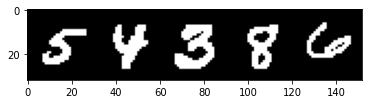

In [7]:
dataiter = iter(valloader)
images,labels = dataiter.next()
images = torch.reshape(images,(-1,1,28,28))
im = torchvision.utils.make_grid(images[:5])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
print(' '.join('%8s' % labels[j].item() for j in range(5)))

In [8]:
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)
        #self.layers = nn.ModuleList(layers)

    def forward(self, x):
        return self.net(x)

In [9]:
def one_epoch(epoch, net, loader, optimizer):
    net.train()
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0
    start_time = time.time()
    for i, data in enumerate(loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 100 == 99:
        #    print(f"\nFinished batch {i} of {train_size/batch_size} \t Timestamp: {time.time() - start_time}")
        # print statistics
    avg_loss = running_loss / total
    acc = correct / total *100
    end_time = time.time()
    print('Training Loss: %.8f \t Time: {%.3f}s'%(avg_loss, end_time - start_time))
    return avg_loss, acc

def train_step(net, loader, dev_loader, optimizer, scheduler, epochs):
    net.train()
    train_losses = []
    valid_losses = []
    valid_acc = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        avg_loss_t, acc_t = one_epoch(epoch, net, loader, optimizer)
        avg_loss_v, acc_v = infer(net, dev_loader)
        scheduler.step()
        if epoch % 5 == 4:
            print('Epoch [%d], loss: %.8f, acc: %.4f' %
                  (epoch + 1, avg_loss_t, acc_t))
            print('[valid] loss: %.8f, acc: %.4f' % (avg_loss_v, acc_v))
            #print("lr: {}".format(optimizer.param_groups[0]['lr']))
            
        train_losses.append(avg_loss_t)
        valid_losses.append(avg_loss_v)
        valid_acc.append(acc_v)
        print('='*20)
        print("*** Saving Checkpoint ***")
        path = "{}optimContDecreaseCont_Epoch_{}_v1.txt".format(weightDirName, str(epoch))
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses,
            'dev_loss':valid_losses,
            'dev_acc': valid_acc
        }, path)
        
    return train_losses, valid_losses

def train(net, loader, dev_loader, optimizer, epochs):
    net.train()
    train_losses = []
    valid_losses = []
    valid_acc = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        avg_loss_t, acc_t = one_epoch(epoch, net, loader, optimizer)
        avg_loss_v, acc_v = infer(net, dev_loader)
        #scheduler.step()
        if epoch % 5 == 4:
            print('Epoch [%d], loss: %.8f, acc: %.4f' %
                  (epoch + 1, avg_loss_t, acc_t))
            print('[valid] loss: %.8f, acc: %.4f' % (avg_loss_v, acc_v))
            #print("lr: {}".format(optimizer.param_groups[0]['lr']))
            
        train_losses.append(avg_loss_t)
        valid_losses.append(avg_loss_v)
        valid_acc.append(acc_v)
        print('='*20)
        print("*** Saving Checkpoint ***")
        path = "{}optimContDecreaseCont_Epoch_{}_v1.txt".format(weightDirName, str(epoch))
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses,
            'dev_loss':valid_losses,
            'dev_acc': valid_acc
        }, path)
        
    return train_losses, valid_losses

def infer(net, loader):
    net.eval()
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            # forward + backward + optimize
            outputs = net(inputs)
            loss = F.cross_entropy(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #if i % 100 == 99:
            #    print(f"\n(Eval)Finished batch{i} of {val_size/batch_size} \t Timestamp: {time.time() - start_time}")

    acc = correct / total * 100
    avg_loss = running_loss / total
    end_time = time.time()
    print('Testing Loss: ', avg_loss)
    print('Testing Accuracy: %.4f'%(acc))
    return avg_loss, acc

### VISUALIZATION ###
def training_plot(loss_t, val_t,val_acc):
    print("*** Visualization***")
    plt.title('Training Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.plot(loss_t)
    plt.savefig("train_loss.png")
    
    plt.title('Dev Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy (%)')
    plt.plot(val_acc)
    plt.savefig("val_loss.png")
    
    
    plt.figure(1)
    plt.plot(loss_t, 'b', label="train")
    plt.plot(val_t, 'g', label="valid")
    plt.title('Training/Valid Loss')
    plt.legend()
    

In [10]:
# Xavier
def init_xavier(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)


Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)
Training Loss: 0.02972084 	 Time: {3.951}s
Testing Loss:  0.008709044605493545
Testing Accuracy: 92.3750
*** Saving Checkpoint ***
Training Loss: 0.00519657 	 Time: {7.507}s
Testing Loss:  0.004899619782964389
Testing Accuracy: 94.0500
*** Saving Checkpoint ***
Training Loss: 0.00270151 	 Time: {7.682}s
Testing Loss:  0.004188226747016112
Testing Accuracy: 94.4417
*** Saving Checkpoint ***
Training Loss: 0.00170866 	 Time: {7.971}s
Testing Loss:  0.003450459219515324
Testing Accuracy: 95.3000
*** Saving Checkpoint ***
Training Loss: 0.00101663 	 Time: {7.851}s
Testing Loss:  0.0032528403451045356
Testing Accuracy: 95.4750
Epoch [5], loss: 0.00101663, acc: 97.5938
[valid] loss: 0.00325284, acc: 95.4750
*** Saving Checkpoint ***
Training Loss: 0.00074568 	 Time: {7.978}s
Testing Loss:  0.003175441468755404
Testin

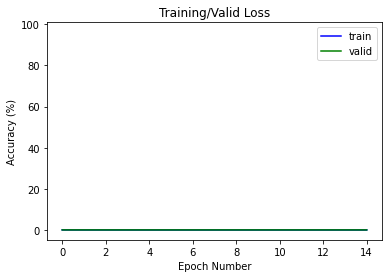

In [11]:
input_size = 784 ## 28*28 image flattened for MLP
output_size = 10 ## 0-9 digits 
model = Simple_MLP([input_size] + hyper["hiddenDims"] + [output_size])
#checkpoint = torch.load(hyper["checkpointPath"])
#model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.apply(init_xavier)
AdamOptimizer = torch.optim.Adam(model.parameters(),lr=hyper["lr"])
#scheduler = torch.optim.lr_scheduler.StepLR(AdamOptimizer, step_size=33, gamma=0.5)
print(model)

#train_losses, valid_losses = train_step(model, trainloader, valloader, AdamOptimizer,scheduler, nEpochs)
train_losses, valid_losses = train(model, trainloader, valloader, AdamOptimizer, nEpochs)
test_loss, acc_test = infer(model, testloader)
#print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses,acc_test)


In [12]:
checkpoint = torch.load(hyper["checkpointPath"])
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [13]:
checkpoint['dev_acc'][-1]

96.15